# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1sb98tNeJJuTwVlHAniPgRNuLR_fKQuZD

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
#IMPORTING NECCESARY LIBRARIES, MODULES ETC
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import zipfile
import os, os.path

First, I start by mounting my drive and unzipping the folder in my drive. I see that the images in the dataset are not organized into train, validate, and test folders, so I first identify the distribution of images in each of the classes.

In [ ]:
#Accessing zip folder via Google Drive
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Lab3 Dataset.zip'
extract_path = '/content/drive/MyDrive/Lab3_Dataset/'

#Unzipping folder
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#Defining path to access each class folder
subdir_path = os.path.join(extract_path, "Lab3_Gestures_Summer")
subdir_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

#Function to count the number of images
def count_images(directory):
    return len([name for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name)) and
                name.lower().endswith(('.png', '.jpg', '.jpeg'))])

#Loop through each class, print number of images and total number of images
tot_images = 0
for subfolder in subdir_list:
    subfolder_path = os.path.join(subdir_path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = count_images(subfolder_path)
        tot_images += num_images
        print(f"Number of images in '{subfolder}': {num_images}")
print(f"Total number of images: {tot_images}")

MessageError: Error: credential propagation was unsuccessful

The distribution of images among the classes is fairly uniform, with our range of images being from 236 in class F to 250 in class G. I now use the splitfolders library, which can create a new directory in my Google Drive that has all the same classes and images, but creates train, validation and test subfolders in a ratio that I provide. I decided on a 70% Train, 15% validate and 15% test, given the amount of photos we have (which is not many).

In [ ]:
!pip install split_folders

In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer', '/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split',seed=999, ratio=(.7,.15,.15))

In [ ]:
split_list = ['train', 'val', 'test']
subdir_path = '/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split'

tot_images = 0
for split in split_list:
    split_path = os.path.join(subdir_path, split)
    if os.path.isdir(split_path):
        print(f"{split} set image distribution:")
        for class_folder in subdir_list:
            class_folder_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_folder_path):
                num_images = count_images(class_folder_path)
                tot_images += num_images
                print(f"  Number of images in class '{class_folder}': {num_images}")
print(f"Total number of images: {tot_images}")

train set image distribution:
  Number of images in class 'A': 177
  Number of images in class 'B': 172
  Number of images in class 'C': 171
  Number of images in class 'D': 172
  Number of images in class 'E': 172
  Number of images in class 'F': 165
  Number of images in class 'G': 175
  Number of images in class 'H': 170
  Number of images in class 'I': 171
val set image distribution:
  Number of images in class 'A': 38
  Number of images in class 'B': 37
  Number of images in class 'C': 36
  Number of images in class 'D': 37
  Number of images in class 'E': 37
  Number of images in class 'F': 35
  Number of images in class 'G': 37
  Number of images in class 'H': 36
  Number of images in class 'I': 36
test set image distribution:
  Number of images in class 'A': 39
  Number of images in class 'B': 38
  Number of images in class 'C': 38
  Number of images in class 'D': 38
  Number of images in class 'E': 38
  Number of images in class 'F': 36
  Number of images in class 'G': 38
  Nu

As seen in the output above, I have successfully distributed the images into train test, and validation sets. Now I need to transform the images to tensors and create DataLoaders for each set.

In [ ]:
def create_loaders(batch_size):
    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    #Create Datasets for each set and apply transformation
    train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/train', transform=transform)
    val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/val', transform=transform)
    test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/test', transform=transform)

    #Create DataLoaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

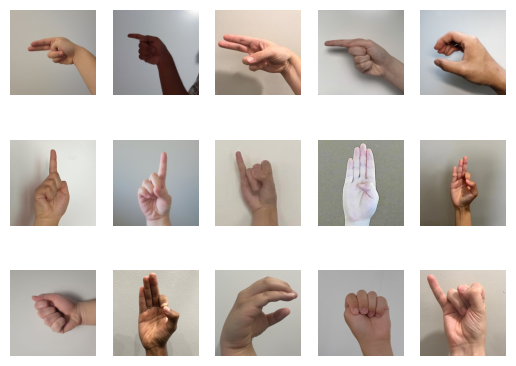

In [ ]:
train_loader, val_loader, test_loader = create_loaders(16)

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

I chose to create a simple CNN architecture to act as a baseline for results. This is a basic architecture that has two convolutional layers, two pooling operations and two fully connected layers. The input image is passed through the first layer with 7 filters of size 4x4, then through a pooling operator with size and stride of 2. It is then passes through the second convolutional operator with 12 filters, then back through the same pooling layer. Finally, the output is flattened and is sent through two fully connected layers, resulting in an output of 9 neurons (one for each class).

In [ ]:
class InitialCNN(nn.Module):
    def __init__(self):
        super(InitialCNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 7, 4) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(7, 12, 4) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53*53*12, 28)
        self.fc2 = nn.Linear(28, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

initial_cnn = InitialCNN()

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def get_accuracy(model, data_loader):

    correct = 0
    total = 0
    for imgs, labels in iter(data_loader):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, batch_size=64, num_epochs=1, learning_rate=0.01):

    train_loader, val_loader, test_loader = create_loaders(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

I chose to use a cross entropy loss function, as this is a multiclass classification problem, so it is the most appropriate choice as it computes loss over c classes. I chose to use stochastic gradient descent with momentum as it can potentially converge to global optima that provide better results than traditional gradient descent.

In [ ]:
!nvidia-smi

Fri Jun 28 00:14:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0              52W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
use_cuda = True

model = InitialCNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
def overfit_train(model, batch_size, num_epochs=1, learning_rate=0.01):

    # Create a small dataset
    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/train', transform=transform)

    # Create a DataLoader for the small dataset
    indices = np.random.choice(len(dataset), size=10, replace=False)  # Sample 10 random indices
    overfit_dataset = Subset(dataset, indices)
    # Create DataLoader for the overfit dataset
    overfit_loader = DataLoader(overfit_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(overfit_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, overfit_loader)) # compute training accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()


    print("Final Training Accuracy: {}".format(train_acc[-1]))

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


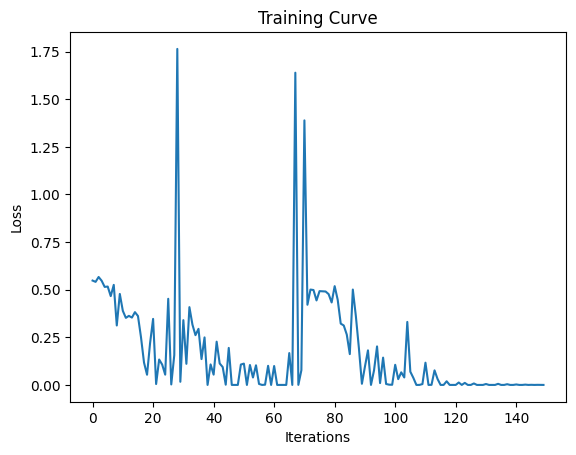

Final Training Accuracy: 1.0


In [ ]:
use_cuda = True

model = InitialCNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

overfit_train(model, batch_size=4, num_epochs=50, learning_rate=0.01)

As seen above, after about 120 iterations we achieve consistent 100% accuracy.

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

I will tune the filter size, batch size and number of epochs as I believe they are the most worth tuning.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train(model, batch_size=256, num_epochs=10, learning_rate=0.01):

    train_loader, val_loader, test_loader = create_loaders(batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        print('Epoch', {epoch + 1}, 'done')

    # plotting

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**MODEL 1: BATCH SIZE TUNING**: I found that using a batch size of 128 balanced training speed and stability.

CUDA is available!  Training on GPU ...
Epoch {1} done
Epoch {2} done
Epoch {3} done
Epoch {4} done
Epoch {5} done
Epoch {6} done
Epoch {7} done
Epoch {8} done
Epoch {9} done
Epoch {10} done


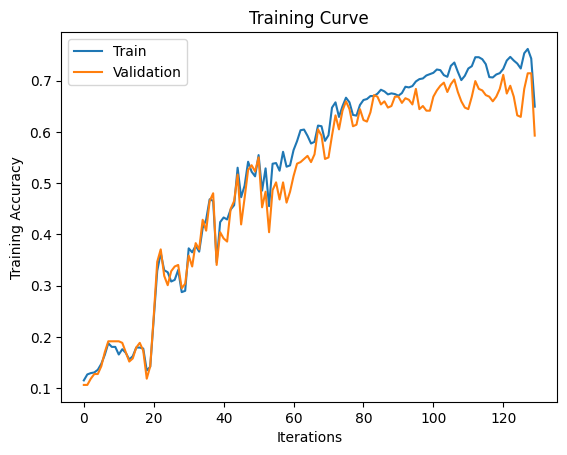

Final Training Accuracy: 0.6491909385113268
Final Validation Accuracy: 0.5927051671732523


In [ ]:
use_cuda = True

model = InitialCNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, batch_size=128, num_epochs=10, learning_rate=0.01)

**MODEL 2: EPOCH TUNING** In this model I double the number of epochs, from 10 to 20

CUDA is available!  Training on GPU ...
Epoch {1} done
Epoch {2} done
Epoch {3} done
Epoch {4} done
Epoch {5} done
Epoch {6} done
Epoch {7} done
Epoch {8} done
Epoch {9} done
Epoch {10} done
Epoch {11} done
Epoch {12} done
Epoch {13} done
Epoch {14} done
Epoch {15} done
Epoch {16} done
Epoch {17} done
Epoch {18} done
Epoch {19} done
Epoch {20} done


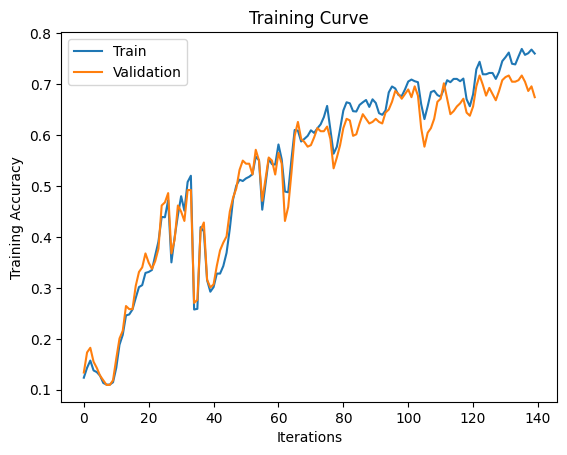

Final Training Accuracy: 0.7605177993527508
Final Validation Accuracy: 0.6747720364741642


In [ ]:
use_cuda = True

model2 = InitialCNN()

if use_cuda and torch.cuda.is_available():
  model2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model2, batch_size=256, num_epochs=20, learning_rate=0.01)

**MODEL 3: FILTER SIZE TUNING**
Below, I build a new model and I decrease the kernel size from 4 to 3.

In [ ]:
class EditedCNN(nn.Module):
    def __init__(self):
        super(EditedCNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 7, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(7, 12, 3) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(54*54*12, 28)
        self.fc2 = nn.Linear(28, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 54*54*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CUDA is available!  Training on GPU ...
Epoch {1} done
Epoch {2} done
Epoch {3} done
Epoch {4} done
Epoch {5} done
Epoch {6} done
Epoch {7} done
Epoch {8} done
Epoch {9} done
Epoch {10} done


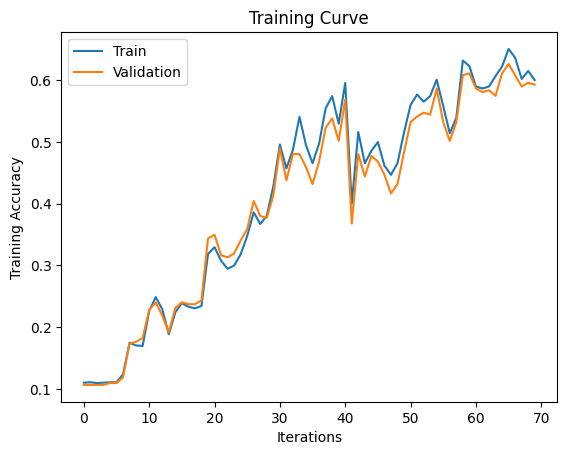

Final Training Accuracy: 0.6
Final Validation Accuracy: 0.5927051671732523


In [ ]:
use_cuda = True

model3 = EditedCNN()

if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model3, batch_size=256, num_epochs=10, learning_rate=0.01)

**Model 4: Filter size and batch size modification** I use the new CNN from model 3, as well as a decreased batch size of 128.

CUDA is available!  Training on GPU ...
Epoch {1} done
Epoch {2} done
Epoch {3} done
Epoch {4} done
Epoch {5} done
Epoch {6} done
Epoch {7} done
Epoch {8} done
Epoch {9} done
Epoch {10} done


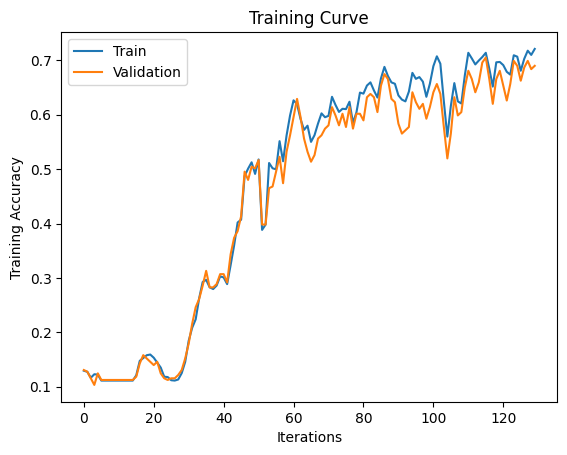

Final Training Accuracy: 0.7210355987055016
Final Validation Accuracy: 0.6899696048632219


In [ ]:
use_cuda = True

model4 = EditedCNN()

if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model4, batch_size=128, num_epochs=10, learning_rate=0.01)

### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best model is model 4, as it achieves the highest validation accuracy.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
def get_accuracy(model):

    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    data = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/test', transform=transform)

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

get_accuracy(model4)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0.6774193548387096

We achieve a final test accuracy of 67.7%

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 190MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
#features = alexnet.features(img)

def create_alexnet_loaders(batch_size):
    train_loader, val_loader, test_loader = create_loaders(batch_size)
    for imgs, labels in iter(train_loader):
        train_features = alexnet.features(imgs)
        break

    for imgs, labels in iter(val_loader):
        val_features = alexnet.features(imgs)
        break

    for imgs, labels in iter(test_loader):
        test_features = alexnet.features(imgs)
        break

    return train_features, val_features, test_features

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

Computed features are saved in `train_features`, `val_features` and `test_features`.



### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
'''output = model(features)
prob = F.softmax(output)'''

'output = model(features)\nprob = F.softmax(output)'

I chose to create a connected neural network with 2 layers that acts as a classifier after feature extraction from AlexNet. It takes in the shape of the input image (6x6x256 channels), and goes through a layer with 28 outputs, then to a final output layer containing probabilties from each of the 9 classes.

In [ ]:
class AlexNetNN(nn.Module):
    def __init__(self):
        super(AlexNetNN, self).__init__()
        self.name = "NN"
        self.fc1 = nn.Linear(6*6*256, 28)
        self.fc2 = nn.Linear(28, 9)

    def forward(self, x):
        x = x.view(-1, 6*6*256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_alexnet = AlexNetNN()

In [ ]:
output = model_alexnet(train_features)
prob = F.softmax(output)

<ipython-input-109-3431f329f9df>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(output)


### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
def train_alexnet(model, train_loader, val_loader, batch_size=256, num_epochs=10, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    n = 0  # the number of iterations
    for epoch in range(num_epochs):
        for data in train_loader:
            imgs, labels = data[:2]

            # Ensure batch size consistency
            if imgs.size(0) != batch_size:
                continue  # Skip the last batch if it's not the same batch size

            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            else:
                print('CUDA is not available. Training on CPU ...')

            out = model(imgs)  # forward pass

            # Debugging shapes
            print(f"Output shape: {out.shape}")
            print(f"Labels shape: {labels.shape}")

            loss = criterion(out, labels)  # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss) / batch_size)  # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader))  # compute training accuracy
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        print('Epoch', epoch + 1, 'done')

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done


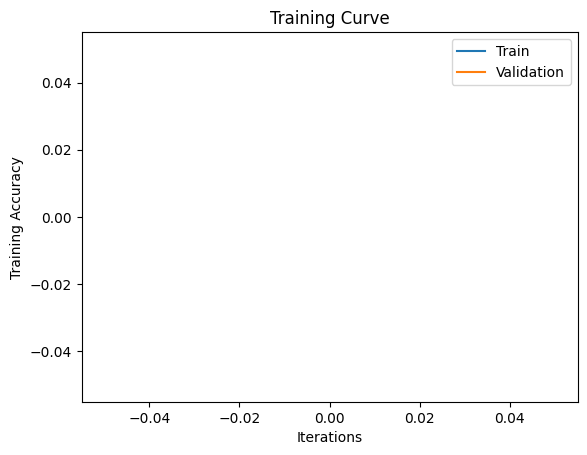

IndexError: list index out of range

In [ ]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model_alexnet.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_loader, val_loader, test_loader = create_alexnet_loaders(batch_size=256)
train_alexnet(model_alexnet, train_loader, val_loader, batch_size=256, num_epochs=10, learning_rate=0.01)

In [ ]:
def get_accuracy(model, loader):

    transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    data = datasets.ImageFolder(root='/content/drive/MyDrive/Lab3_Dataset/Lab3_Gestures_Summer_Split/test', transform=transform)

    correct = 0
    total = 0
    for data in iter(loader):
        imgs, labels = data[:2]

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
get_accuracy(model_alexnet, test_loader)

RuntimeError: shape '[-1, 9216]' is invalid for input of size 36

I was not able to run the AlexNet model properly, but I am very confident that it would perform much better than my model made from scratch.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab3_Gesture_Recognition.ipynb"

[NbConvertApp] Converting notebook /content/Lab3_Gesture_Recognition.ipynb to html
[NbConvertApp] Writing 1229177 bytes to /content/Lab3_Gesture_Recognition.html
